In [1]:
import pandas as pd
import torch
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import math, random, torch, collections, time, torch.nn.functional as F, networkx as nx, matplotlib.pyplot as plt, numpy as np
from torch.nn import Linear
from torch_geometric.nn import GCNConv
from IPython.display import clear_output
from torch_geometric.utils import to_networkx
from torch_geometric.utils import from_networkx

In [2]:
import sys, os
sys.path.append('../../gnumap/')
from models.train_models import *
from scipy import optimize

dev = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
from codecarbon import OfflineEmissionsTracker
from umap_functions import *
from simulation_utils import make_roll

In [3]:
N_NEIGHBOURS = 5


In [4]:
[x,y,z], t, new_data = make_roll(n_neighbours = N_NEIGHBOURS, scale=0.1, n_samples = 4000, features='coordinates')

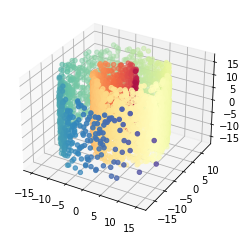

In [5]:
import matplotlib.pyplot as plt
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter3D(x, y, z, c=t, cmap='Spectral')

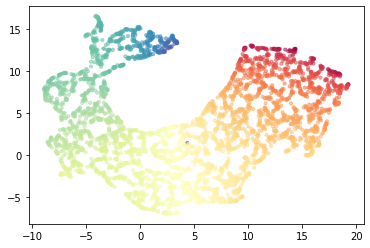

In [6]:
import umap
from sklearn.neighbors import kneighbors_graph

X = np.vstack([np.array(x),np.array(y),np.array(z)]).T
A_dist = kneighbors_graph(X, N_NEIGHBOURS, mode='distance', include_self=False)
embedding = umap.UMAP(n_components=2, n_neighbors= 10, min_dist= 0.3).fit_transform(X)
plt.scatter(*embedding.T, s=10, c=t, alpha=0.5, cmap='Spectral')

<Figure size 432x288 with 0 Axes>

/var/folders/5d/vnx7yths3n3f_d7862mdryz80000gn/T/ipykernel_84604/1726087765.py:3: DeprecationWarning: 

The scipy.sparse array containers will be used instead of matrices
in Networkx 3.0. Use `from_scipy_sparse_array` instead.
  nx.draw_networkx(nx.from_scipy_sparse_matrix(A_dist),


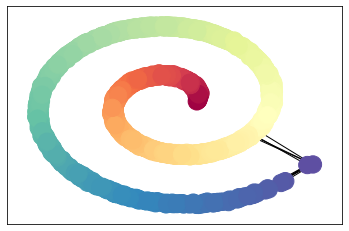

In [7]:
### Very sensitive to wrong edges
plt.figure()
nx.draw_networkx(nx.from_scipy_sparse_matrix(A_dist), 
                 pos={i:[new_data.x[i,0].numpy(),new_data.x[i,1].numpy()] for i in range(new_data.num_nodes)}, 
                 node_color=t, cmap='Spectral', with_labels=False)
plt.show()

=== train SelfGCon model ===


(array([[  21.,  212.,  844., 1068.,  751.,  616.,  346.,  123.,   19.,
            0.],
        [   0.,    0.,    0.,    0.,  300., 1930.,  733.,  540.,  473.,
           24.]]),
 array([-38.522564 , -29.62514  , -20.727715 , -11.830289 ,  -2.9328637,
          5.9645615,  14.861986 ,  23.75941  ,  32.656837 ,  41.55426  ,
         50.451687 ], dtype=float32),
 <a list of 2 BarContainer objects>)

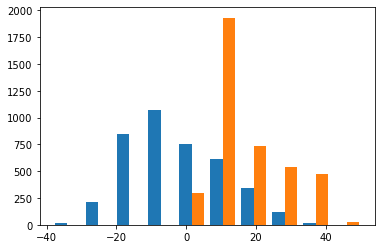

<Figure size 432x288 with 0 Axes>

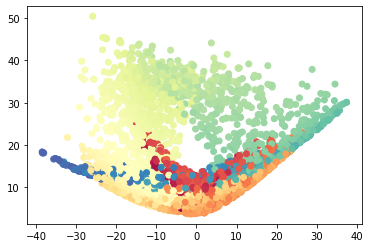

In [8]:
model = train_cca_ssg(new_data, channels=2, hid_dim=256, lambd=1e2,
                  n_layers=2, epochs=1000, lr=1e-2,
                  fmr=0.2, edr =0.4, name_file="test",
                  device=None)
plt.hist(model.get_embedding(new_data).numpy())
plt.show()
plt.figure()
out = model.get_embedding(new_data).numpy()
u = out
plt.scatter(u[:,0], u[:,1], c = t, 
            cmap="Spectral")
plt.show()

=== train DGI model ===
Epoch=000, loss=0.6692, time=0.1870
Epoch=001, loss=0.6481, time=0.1606
Epoch=002, loss=0.6292, time=0.1710
Epoch=003, loss=0.6257, time=0.1880
Epoch=004, loss=0.6187, time=0.1782
Epoch=005, loss=0.6100, time=0.1618
Epoch=006, loss=0.6027, time=0.1567
Epoch=007, loss=0.6029, time=0.1633
Epoch=008, loss=0.5939, time=0.1598
Epoch=009, loss=0.5880, time=0.1830
Epoch=010, loss=0.5881, time=0.1667
Epoch=011, loss=0.5804, time=0.1724
Epoch=012, loss=0.5750, time=0.1701
Epoch=013, loss=0.5709, time=0.1652
Epoch=014, loss=0.5717, time=0.1576
Epoch=015, loss=0.5688, time=0.1588
Epoch=016, loss=0.5586, time=0.1729
Epoch=017, loss=0.5535, time=0.1660
Epoch=018, loss=0.5532, time=0.1689
Epoch=019, loss=0.5438, time=0.1665
Epoch=020, loss=0.5381, time=0.1546
Epoch=021, loss=0.5360, time=0.1656
Epoch=022, loss=0.5347, time=0.1669
Epoch=023, loss=0.5251, time=0.1571
Epoch=024, loss=0.5255, time=0.1573
Epoch=025, loss=0.5159, time=0.1619
Epoch=026, loss=0.5113, time=0.1654
Epoc

(array([[ 188., 2036., 1537.,  239.,    0.,    0.,    0.,    0.,    0.,
            0.],
        [   0.,  444.,  995., 1186.,  877.,  291.,   95.,   65.,   37.,
           10.]]),
 array([-5.4169827, -1.6534586,  2.1100655,  5.8735895,  9.637114 ,
        13.400638 , 17.164162 , 20.927685 , 24.69121  , 28.454735 ,
        32.218258 ], dtype=float32),
 <a list of 2 BarContainer objects>)

<Figure size 432x288 with 0 Axes>

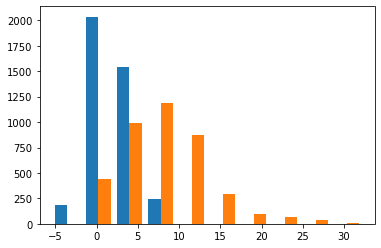

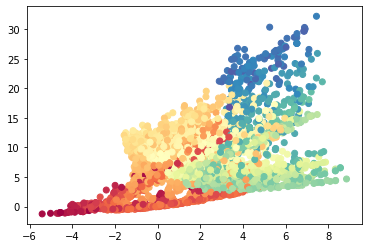

In [9]:
model = train_dgi(new_data,512, 2, 2, patience=20,
              epochs=200, lr=1e-3, name_file="1")
plt.hist(model.get_embedding(new_data).numpy())
plt.figure()
out = model.get_embedding(new_data).numpy()
u = out
plt.scatter(u[:,0], u[:,1], c = t, 
            cmap="Spectral")
plt.show()

In [108]:
from numbers import Number
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

from models.aggregation import GAPPNP
class GNN(nn.Module):
    def __init__(self, input_dim: int, hidden_dim: int,
                 output_dim: int, n_layers: int,
                 activation: str='relu', slope: float=.1,
                 device: str='cpu',
                 alpha_res: float=0, alpha: float=0.5,
                 beta: float=1., gnn_type: str = 'symmetric',
                 norm: str='normalize',
                 must_propagate=None,
                 lambd_corr: float = 0):
        super().__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.gnn_type = gnn_type
        self.n_layers = n_layers
        self.device = device
        self.alpha_res = alpha_res
        self.alpha = alpha
        self.beta= beta
        self.must_propagate = must_propagate
        self.propagate = GAPPNP(K=1, alpha_res=self.alpha_res,
                                alpha = self.alpha,
                                gnn_type=self.gnn_type,
                                beta = self.beta)
        self.norm = norm
        if self.must_propagate is None:
            self.must_propagate = [True] * self.n_layers
        if isinstance(hidden_dim, Number):
            self.hidden_dim = [hidden_dim] * (self.n_layers - 1)
        elif isinstance(hidden_dim, list):
            self.hidden_dim = hidden_dim
        else:
            raise ValueError('Wrong argument type for hidden_dim: {}'.format(hidden_dim))

        if isinstance(activation, str):
            self.activation = [activation] * (self.n_layers - 1)
        elif isinstance(activation, list):
            self.hidden_dim = activation
        else:
            raise ValueError('Wrong argument type for activation: {}'.format(activation))

        self._act_f = []
        for act in self.activation:
            if act == 'lrelu':
                self._act_f.append(lambda x: F.leaky_relu(x, negative_slope=slope))
            elif act == 'relu':
                self._act_f.append(lambda x: torch.nn.ReLU()(x))
            elif act == 'xtanh':
                self._act_f.append(lambda x: self.xtanh(x, alpha=slope))
            elif act == 'sigmoid':
                self._act_f.append(F.sigmoid)
            elif act == 'none':
                self._act_f.append(lambda x: x)
            else:
                ValueError('Incorrect activation: {}'.format(act))

        if self.n_layers == 1:
            _fc_list = [nn.Linear(self.input_dim, self.output_dim)]
        else:
            _fc_list = [nn.Linear(self.input_dim, self.hidden_dim[0])]
            for i in range(1, self.n_layers - 1):
                _fc_list.append(nn.Linear(self.hidden_dim[i - 1], self.hidden_dim[i]))
            _fc_list.append(nn.Linear(self.hidden_dim[self.n_layers - 2], self.output_dim))
        self.fc = nn.ModuleList(_fc_list)
        self.to(self.device)

    @staticmethod
    def xtanh(x, alpha=.1):
        """tanh function plus an additional linear term"""
        return x.tanh() + alpha * x

    def forward(self, x, edge_index):
        h = x
        for c in range(self.n_layers):
            if c == self.n_layers - 1:
                h = self.fc[c](h)
                if self.norm == 'normalize' and c==0:
                    h = F.normalize(h, p=2, dim=1)
                elif self.norm == 'standardize'and c==0:
                    h = (h - h.mean(0)) / h.std(0)
                elif self.norm == 'uniform'and c==0:
                    h = 1 * (h - h.min()) / (h.max() - h.min())
                elif self.norm == 'col_uniform'and c==0:
                    h = 1 * (h - h.min(0)[0].reshape([1,-1]))/ (h.max(0)[0].reshape([1,-1])-h.min(0)[0].reshape([1,-1]))

            else:
                h = self.fc[c](h)
                h = F.dropout(h, p=0.5, training=self.training)
                if self.must_propagate[c]:
                    h = self.propagate(h, edge_index)
                if self.norm == 'normalize':
                    h = F.normalize(h, p=2, dim=1)
                elif self.norm == 'standardize':
                    h = (h - h.mean(0)) / h.std(0) #z1 = (h1 - h1.mean(0)) / h1.std(0)
                elif self.norm == 'uniform':
                    h = 1 * (h - h.min()) / (h.max() - h.min())
                elif self.norm == 'col_uniform':
                    h = 1 * (h - h.min(0)[0].reshape([1,-1]))/ (h.max(0)[0].reshape([1,-1])-h.min(0)[0].reshape([1,-1]))
                h = self._act_f[c](h)
        if self.norm == 'standardize_last':
            h = (h - h.mean(0)) / h.std(0)
        return h


In [118]:
import numpy as np
from carbontracker.tracker import CarbonTracker
import cProfile
import os
import scipy
import torch
import torch.nn as nn
import torch_geometric
from torch_geometric.data import Data
from torch_geometric.utils import remove_self_loops, negative_sampling
from torch_geometric.utils import add_remaining_self_loops
from torch_geometric.utils import to_scipy_sparse_matrix, to_networkx, from_scipy_sparse_matrix
import time
from umap_functions import *

def train_gnumap(data, hid_dim, dim, n_layers=2, target=None,
                 method = 'laplacian', must_propagate=None,
                 norm='normalize', neighbours=15,
                 patience=20, epochs=200, lr=1e-3, wd=1e-2,
                 min_dist=0.1, name_file="1", subsampling=None,
                 alpha: float=0.5, spread = 1.0, lambd_corr=1e-2,
                 beta: float=1., gnn_type: str = 'symmetric',
                 repulsion_strength=None,
                 local_connectivity=1,
                 device=None, colours=None):


    if device is None:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    EPS_0 = data.num_edges/ (data.num_nodes ** 2)
    _a, _b = find_ab_params(spread, min_dist)

    if torch_geometric.utils.is_undirected(data.edge_index):
        new_edge_index, new_edge_attr = torch_geometric.utils.to_undirected(data.edge_index, data.edge_weight)
    else:
        new_edge_index, new_edge_attr = data.edge_index, data.edge_weight
    #### transform edge index into knn matrix
    knn = []
    for i in range(data.num_nodes):
        knn += [list(np.sort(list(new_edge_attr[(new_edge_index[0]==i) & (new_edge_index[1]!=i )].numpy())))]
    knn_dists = pd.DataFrame(knn).fillna(0).values
    sigmas, rhos = smooth_knn_dist(
            knn_dists,
            float(neighbours),
            local_connectivity=float(local_connectivity),
             )
    vals = [ np.exp(-(np.max([new_edge_attr.numpy()[i] - rhos[new_edge_index[0,i]], 0])) /
                    (sigmas[new_edge_index[0,i]])) for i in range(len(new_edge_attr))]
    #print(np.where(vals > 1e5))
    rows = new_edge_index[0,:].numpy()
    cols = new_edge_index[1,:].numpy()
    vals = np.array(vals)
    vals[vals<1e-5] = 0
    result = scipy.sparse.coo_matrix(
        (vals, (rows, cols)), shape=(X.shape[0], X.shape[0])
    )
    result.eliminate_zeros()
    target_graph_index, target_graph_weights = from_scipy_sparse_matrix(result)



    #### Prune
    EPS = 1e-29#math.exp(-1.0/(2*_b) * math.log(1.0/_a * (1.0/EPS_0 -1)))
    print("Epsilon is " + str(EPS))
    print("Hyperparameters a = " + str(_a) + " and b = " + str(_b))



    model = GNN(data.num_features, hid_dim, dim, n_layers=n_layers,
                must_propagate=must_propagate,
                norm=norm)
    model = model.to(device)
    model.apply(init_weights)

    optimizer = torch.optim.Adam(model.parameters(), lr=lr,
                             weight_decay=wd)
    new_data = Data(x=data.x, edge_index=target_graph_index,
                    y=data.y, edge_weight=target_graph_weights)
    sparsity =  new_data.num_edges/(new_data.num_nodes**2 -new_data.num_nodes)
    if repulsion_strength is None:
        repulsion_strength = 1.0/sparsity
    row_pos, col_pos =  new_data.edge_index
    index = (row_pos != col_pos)
    edge_weights_pos = new_data.edge_weight#[index]

    if target is not None:
        edge_weights_pos = fast_intersection(row_pos[index], col_pos[index], edge_weights_pos,
                                             target, unknown_dist=1.0, far_dist=5.0)

    if subsampling is None:
        row_neg, col_neg = negative_sampling(new_data.edge_index, num_neg_samples = 5 * new_data.edge_index.shape[1] )
        index_neg = (row_neg != col_neg)
        edge_weights_neg = EPS * torch.ones(len(row_neg))
        if target is not None:
            edge_weights_neg = fast_intersection(row_neg[index_neg], col_neg[index_neg], edge_weights_neg,
                                                 target, unknown_dist=1.0, far_dist=5.0)
    best_t=0
    cnt_wait = 0
    best=1e9
    log_sigmoid = torch.nn.LogSigmoid()
    edges = [(e[0],e[1]) for _, e in enumerate(data.edge_index.numpy().T)]
    for epoch in range(epochs):
        tic_epoch = time.time()
        model.train()
        optimizer.zero_grad()
        tic = time.time()
        out = model(data.x.float(), data.edge_index)
        diff_norm = torch.sum(torch.square(out[row_pos[index]] - out[col_pos[index]]), 1)
        diff_norm = torch.clip(diff_norm, min=1e-3)
        log_q = torch.log1p(_a *  diff_norm ** _b)
        loss_pos = - torch.mean(edge_weights_pos[index] * log_sigmoid(log_q)) - torch.mean((1. - edge_weights_pos[index]) *  (log_sigmoid(log_q) - log_q ) * repulsion_strength)

        if subsampling is None:
            diff_norm_neg = torch.sum(torch.square(out[row_neg[index_neg]] - out[col_neg[index_neg]]), 1) #+ 1e-3
            diff_norm_neg = torch.clip(diff_norm_neg, min=1e-3)
            log_q_neg = torch.log1p(_a *  diff_norm_neg ** _b)
        else:
            row_neg, col_neg = negative_sampling(new_data.edge_index,
                                                 num_neg_samples=subsampling)
            index_neg = (row_neg != col_neg)
            edge_weights_neg = EPS * torch.ones(len(row_neg))
            if target is not None:
                edge_weights_neg = fast_intersection(row_neg[index_neg],
                                                     col_neg[index_neg], edge_weights_neg,
                                                     target, unknown_dist=1.0, far_dist=5.0)
            diff_norm_neg = torch.sum(torch.square(out[row_neg[index_neg]] - out[col_neg[index_neg]]), 1) #+ 1e-3
            diff_norm_neg = torch.clip(diff_norm_neg, min=1e-3)
            log_q_neg = torch.log1p(_a *  diff_norm_neg ** _b)
        print("loss before neg", loss_pos)
        loss_neg = - torch.mean((log_sigmoid(log_q_neg) - log_q_neg ) * repulsion_strength)
        print("loss after neg", loss_neg)
        ### Add a term to make sure that the features are learned independently
        c1 = torch.mm(out.T, out)
        c1 = c1 / out.shape[0]
        iden = torch.tensor(np.eye(out.shape[1])).to(device)
        loss_dec1 = (torch.diag_embed(c1) - c1).pow(2).sum()
        loss = loss_pos + loss_neg +  lambd_corr * loss_dec1
        print("loss corr", lambd_corr * loss_dec1)
        print("loss final", loss)
        tic =  time.time()
        loss.backward()
        #torch.nn.utils.clip_grad_value_(model.parameters(), clip_value=4)
        optimizer.step()
        
        if epoch%10== 0:
            u = out.detach().numpy()
            plt.figure()
            plt.scatter(u[:,0], u[:,1], c = t, 
                        cmap="Spectral")
            plt.show()
            print(torch.mm(out.T, out)/ new_data.num_nodes)

        for g in optimizer.param_groups:
            g['lr'] = lr * (1.0 - (float(epoch) / float(epochs)))

        print('Epoch={:03d}, loss={:.4f}, time={:.4f}'.format(epoch, loss.item(),time.time()-tic_epoch))
        if loss < best:
            best = loss
            best_t = epoch
            cnt_wait = 0
            torch.save(model.state_dict(), os.getcwd()  + '/results/best_gnumap_'
                                          + str(method) + '_neigh' + str(neighbours)
                                          + '_dim' + str(dim) + '_' + name_file +  '.pkl')
        else:
            cnt_wait += 1
        if cnt_wait == patience and epoch>50:
            print('Early stopping at epoch {}!'.format(epoch))
            break
        #print("Time epoch after saving", time.time()-tic_epoch)
    #tracker.stop()
    print('Loading {}th epoch'.format(best_t))
    model.load_state_dict(torch.load(os.getcwd()  + '/results/best_gnumap_' +
                                     str(method) + '_neigh' + str(neighbours)
                                     + '_dim' + str(dim) + '_' + name_file + '.pkl'))
    return(model,target_graph_index, vals, knn_dists)

Epsilon is 1e-29
Hyperparameters a = 1.89560586638432 and b = 0.8006378440415777
loss before neg tensor(18.3886, dtype=torch.float64, grad_fn=<SubBackward0>)
loss after neg tensor(70.8677, grad_fn=<NegBackward0>)
loss corr tensor(9.7630e-05, grad_fn=<MulBackward0>)
loss final tensor(89.2564, dtype=torch.float64, grad_fn=<AddBackward0>)


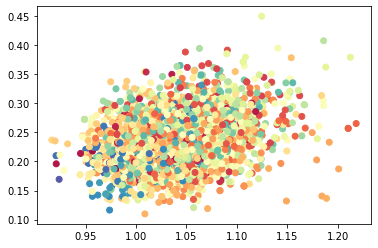

tensor([[1.0823, 0.2446],
        [0.2446, 0.0568]], grad_fn=<DivBackward0>)
Epoch=000, loss=89.2564, time=1.0203
loss before neg tensor(36.1404, dtype=torch.float64, grad_fn=<SubBackward0>)
loss after neg tensor(109.7686, grad_fn=<NegBackward0>)
loss corr tensor(23.3682, grad_fn=<MulBackward0>)
loss final tensor(169.2772, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch=001, loss=169.2772, time=0.9286
loss before neg tensor(77.9852, dtype=torch.float64, grad_fn=<SubBackward0>)
loss after neg tensor(212.8983, grad_fn=<NegBackward0>)
loss corr tensor(0.1401, grad_fn=<MulBackward0>)
loss final tensor(291.0236, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch=002, loss=291.0236, time=0.8957
loss before neg tensor(82.6252, dtype=torch.float64, grad_fn=<SubBackward0>)
loss after neg tensor(227.5511, grad_fn=<NegBackward0>)
loss corr tensor(27.8224, grad_fn=<MulBackward0>)
loss final tensor(337.9988, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch=003, loss=337.9988, time=0.8735
loss 

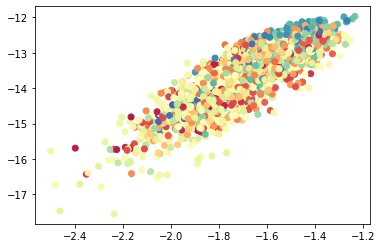

tensor([[  2.7419,  22.1932],
        [ 22.1932, 180.3078]], grad_fn=<DivBackward0>)
Epoch=010, loss=169.8067, time=1.0684
loss before neg tensor(27.4315, dtype=torch.float64, grad_fn=<SubBackward0>)
loss after neg tensor(89.1423, grad_fn=<NegBackward0>)
loss corr tensor(24.0483, grad_fn=<MulBackward0>)
loss final tensor(140.6221, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch=011, loss=140.6221, time=0.8955
loss before neg tensor(24.6139, dtype=torch.float64, grad_fn=<SubBackward0>)
loss after neg tensor(84.2234, grad_fn=<NegBackward0>)
loss corr tensor(16.1608, grad_fn=<MulBackward0>)
loss final tensor(124.9980, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch=012, loss=124.9980, time=0.9698
loss before neg tensor(28.1260, dtype=torch.float64, grad_fn=<SubBackward0>)
loss after neg tensor(90.0668, grad_fn=<NegBackward0>)
loss corr tensor(4.1031, grad_fn=<MulBackward0>)
loss final tensor(122.2959, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch=013, loss=122.2959, time=0.9053

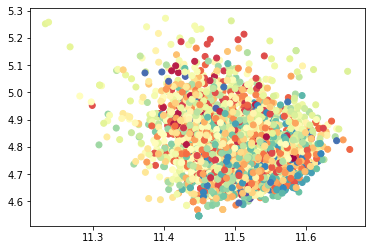

tensor([[132.3396,  55.1917],
        [ 55.1917,  23.0303]], grad_fn=<DivBackward0>)
Epoch=020, loss=95.8846, time=1.4790
loss before neg tensor(22.0067, dtype=torch.float64, grad_fn=<SubBackward0>)
loss after neg tensor(77.3958, grad_fn=<NegBackward0>)
loss corr tensor(2.9164, grad_fn=<MulBackward0>)
loss final tensor(102.3189, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch=021, loss=102.3189, time=0.9586
loss before neg tensor(21.0056, dtype=torch.float64, grad_fn=<SubBackward0>)
loss after neg tensor(75.7554, grad_fn=<NegBackward0>)
loss corr tensor(6.4234, grad_fn=<MulBackward0>)
loss final tensor(103.1844, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch=022, loss=103.1844, time=0.9592
loss before neg tensor(18.6321, dtype=torch.float64, grad_fn=<SubBackward0>)
loss after neg tensor(71.4334, grad_fn=<NegBackward0>)
loss corr tensor(4.3444, grad_fn=<MulBackward0>)
loss final tensor(94.4099, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch=023, loss=94.4099, time=0.9536
loss

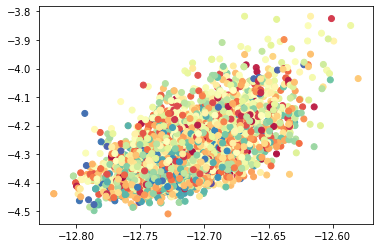

tensor([[161.5912,  54.5335],
        [ 54.5335,  18.4127]], grad_fn=<DivBackward0>)
Epoch=030, loss=95.5954, time=1.1976
loss before neg tensor(19.3707, dtype=torch.float64, grad_fn=<SubBackward0>)
loss after neg tensor(72.2734, grad_fn=<NegBackward0>)
loss corr tensor(1.6147, grad_fn=<MulBackward0>)
loss final tensor(93.2589, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch=031, loss=93.2589, time=0.9955
loss before neg tensor(18.2404, dtype=torch.float64, grad_fn=<SubBackward0>)
loss after neg tensor(70.2864, grad_fn=<NegBackward0>)
loss corr tensor(1.4911, grad_fn=<MulBackward0>)
loss final tensor(90.0179, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch=032, loss=90.0179, time=1.0225
loss before neg tensor(18.6778, dtype=torch.float64, grad_fn=<SubBackward0>)
loss after neg tensor(70.8552, grad_fn=<NegBackward0>)
loss corr tensor(0.3920, grad_fn=<MulBackward0>)
loss final tensor(89.9250, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch=033, loss=89.9250, time=1.0372
loss bef

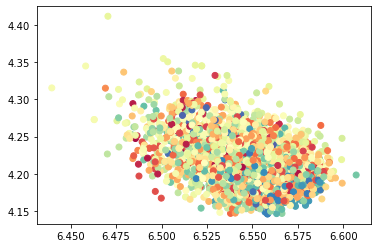

tensor([[42.8573, 27.5792],
        [27.5792, 17.7490]], grad_fn=<DivBackward0>)
Epoch=040, loss=88.8024, time=1.2797
loss before neg tensor(18.1783, dtype=torch.float64, grad_fn=<SubBackward0>)
loss after neg tensor(69.9910, grad_fn=<NegBackward0>)
loss corr tensor(0.4051, grad_fn=<MulBackward0>)
loss final tensor(88.5744, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch=041, loss=88.5744, time=1.0768
loss before neg tensor(18.3268, dtype=torch.float64, grad_fn=<SubBackward0>)
loss after neg tensor(70.1239, grad_fn=<NegBackward0>)
loss corr tensor(0.3139, grad_fn=<MulBackward0>)
loss final tensor(88.7647, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch=042, loss=88.7647, time=1.0423
loss before neg tensor(18.5107, dtype=torch.float64, grad_fn=<SubBackward0>)
loss after neg tensor(70.4522, grad_fn=<NegBackward0>)
loss corr tensor(0.2723, grad_fn=<MulBackward0>)
loss final tensor(89.2353, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch=043, loss=89.2353, time=1.0207
loss before 

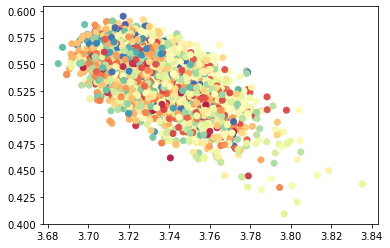

tensor([[13.9168,  2.0126],
        [ 2.0126,  0.2917]], grad_fn=<DivBackward0>)
Epoch=050, loss=88.2148, time=1.2810
loss before neg tensor(18.2776, dtype=torch.float64, grad_fn=<SubBackward0>)
loss after neg tensor(69.9924, grad_fn=<NegBackward0>)
loss corr tensor(0.0086, grad_fn=<MulBackward0>)
loss final tensor(88.2786, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch=051, loss=88.2786, time=1.0321
loss before neg tensor(18.1373, dtype=torch.float64, grad_fn=<SubBackward0>)
loss after neg tensor(69.7849, grad_fn=<NegBackward0>)
loss corr tensor(0.0084, grad_fn=<MulBackward0>)
loss final tensor(87.9306, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch=052, loss=87.9306, time=1.0233
loss before neg tensor(18.1147, dtype=torch.float64, grad_fn=<SubBackward0>)
loss after neg tensor(69.7484, grad_fn=<NegBackward0>)
loss corr tensor(0.0063, grad_fn=<MulBackward0>)
loss final tensor(87.8693, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch=053, loss=87.8693, time=1.0227
loss before 

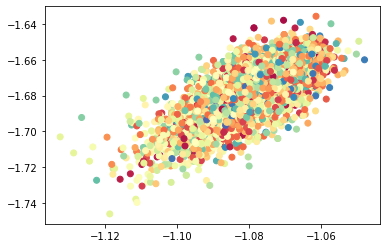

tensor([[1.1668, 1.8131],
        [1.8131, 2.8173]], grad_fn=<DivBackward0>)
Epoch=060, loss=87.8608, time=1.2566
loss before neg tensor(18.0871, dtype=torch.float64, grad_fn=<SubBackward0>)
loss after neg tensor(69.6952, grad_fn=<NegBackward0>)
loss corr tensor(0.0028, grad_fn=<MulBackward0>)
loss final tensor(87.7851, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch=061, loss=87.7851, time=1.0467
loss before neg tensor(18.1055, dtype=torch.float64, grad_fn=<SubBackward0>)
loss after neg tensor(69.7258, grad_fn=<NegBackward0>)
loss corr tensor(0.0040, grad_fn=<MulBackward0>)
loss final tensor(87.8354, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch=062, loss=87.8354, time=1.0513
loss before neg tensor(18.1451, dtype=torch.float64, grad_fn=<SubBackward0>)
loss after neg tensor(69.7801, grad_fn=<NegBackward0>)
loss corr tensor(0.0080, grad_fn=<MulBackward0>)
loss final tensor(87.9332, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch=063, loss=87.9332, time=1.0596
loss before neg 

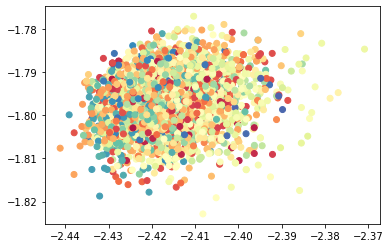

tensor([[5.8441, 4.3440],
        [4.3440, 3.2290]], grad_fn=<DivBackward0>)
Epoch=070, loss=87.7873, time=1.2749
loss before neg tensor(18.0984, dtype=torch.float64, grad_fn=<SubBackward0>)
loss after neg tensor(69.7139, grad_fn=<NegBackward0>)
loss corr tensor(0.0095, grad_fn=<MulBackward0>)
loss final tensor(87.8218, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch=071, loss=87.8218, time=1.0428
loss before neg tensor(18.0918, dtype=torch.float64, grad_fn=<SubBackward0>)
loss after neg tensor(69.7029, grad_fn=<NegBackward0>)
loss corr tensor(0.0077, grad_fn=<MulBackward0>)
loss final tensor(87.8024, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch=072, loss=87.8024, time=1.0397
loss before neg tensor(18.0871, dtype=torch.float64, grad_fn=<SubBackward0>)
loss after neg tensor(69.6915, grad_fn=<NegBackward0>)
loss corr tensor(0.0077, grad_fn=<MulBackward0>)
loss final tensor(87.7863, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch=073, loss=87.7863, time=1.0412
loss before neg 

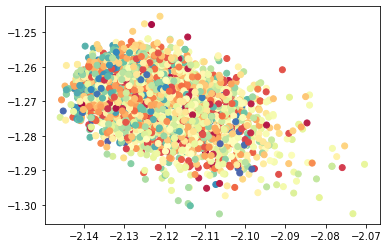

tensor([[4.5059, 2.6949],
        [2.6949, 1.6119]], grad_fn=<DivBackward0>)
Epoch=080, loss=87.7977, time=1.2740
loss before neg tensor(18.0917, dtype=torch.float64, grad_fn=<SubBackward0>)
loss after neg tensor(69.6977, grad_fn=<NegBackward0>)
loss corr tensor(0.0025, grad_fn=<MulBackward0>)
loss final tensor(87.7919, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch=081, loss=87.7919, time=1.0385
loss before neg tensor(18.0871, dtype=torch.float64, grad_fn=<SubBackward0>)
loss after neg tensor(69.6903, grad_fn=<NegBackward0>)
loss corr tensor(0.0016, grad_fn=<MulBackward0>)
loss final tensor(87.7790, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch=082, loss=87.7790, time=1.0301
loss before neg tensor(18.0870, dtype=torch.float64, grad_fn=<SubBackward0>)
loss after neg tensor(69.6897, grad_fn=<NegBackward0>)
loss corr tensor(0.0007, grad_fn=<MulBackward0>)
loss final tensor(87.7774, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch=083, loss=87.7774, time=1.0481
loss before neg 

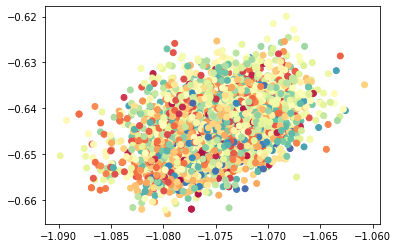

tensor([[1.1564, 0.6933],
        [0.6933, 0.4157]], grad_fn=<DivBackward0>)
Epoch=090, loss=87.7769, time=1.3274
loss before neg tensor(18.0870, dtype=torch.float64, grad_fn=<SubBackward0>)
loss after neg tensor(69.6898, grad_fn=<NegBackward0>)
loss corr tensor(0.0001, grad_fn=<MulBackward0>)
loss final tensor(87.7768, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch=091, loss=87.7768, time=1.0583
loss before neg tensor(18.0871, dtype=torch.float64, grad_fn=<SubBackward0>)
loss after neg tensor(69.6902, grad_fn=<NegBackward0>)
loss corr tensor(0.0002, grad_fn=<MulBackward0>)
loss final tensor(87.7775, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch=092, loss=87.7775, time=1.0603
loss before neg tensor(18.0871, dtype=torch.float64, grad_fn=<SubBackward0>)
loss after neg tensor(69.6902, grad_fn=<NegBackward0>)
loss corr tensor(0.0001, grad_fn=<MulBackward0>)
loss final tensor(87.7774, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch=093, loss=87.7774, time=1.0654
loss before neg 

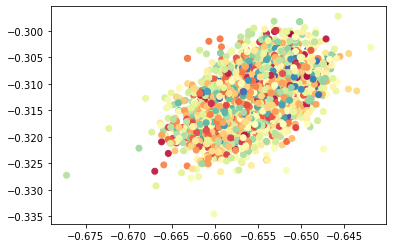

tensor([[0.4293, 0.2045],
        [0.2045, 0.0974]], grad_fn=<DivBackward0>)
Epoch=100, loss=87.7767, time=1.2856
loss before neg tensor(18.0870, dtype=torch.float64, grad_fn=<SubBackward0>)
loss after neg tensor(69.6897, grad_fn=<NegBackward0>)
loss corr tensor(2.0678e-05, grad_fn=<MulBackward0>)
loss final tensor(87.7767, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch=101, loss=87.7767, time=1.0650
loss before neg tensor(18.0870, dtype=torch.float64, grad_fn=<SubBackward0>)
loss after neg tensor(69.6898, grad_fn=<NegBackward0>)
loss corr tensor(1.4962e-05, grad_fn=<MulBackward0>)
loss final tensor(87.7767, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch=102, loss=87.7767, time=1.0559
loss before neg tensor(18.0871, dtype=torch.float64, grad_fn=<SubBackward0>)
loss after neg tensor(69.6901, grad_fn=<NegBackward0>)
loss corr tensor(7.2323e-06, grad_fn=<MulBackward0>)
loss final tensor(87.7773, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch=103, loss=87.7773, time=1.0481
loss

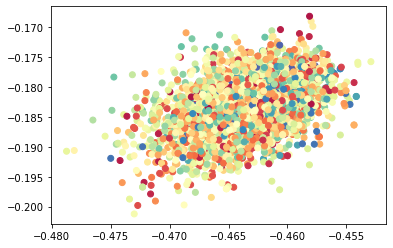

tensor([[0.2146, 0.0849],
        [0.0849, 0.0336]], grad_fn=<DivBackward0>)
Epoch=110, loss=87.7767, time=1.2747
loss before neg tensor(18.0870, dtype=torch.float64, grad_fn=<SubBackward0>)
loss after neg tensor(69.6897, grad_fn=<NegBackward0>)
loss corr tensor(2.5698e-06, grad_fn=<MulBackward0>)
loss final tensor(87.7767, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch=111, loss=87.7767, time=1.0835
loss before neg tensor(18.0870, dtype=torch.float64, grad_fn=<SubBackward0>)
loss after neg tensor(69.6897, grad_fn=<NegBackward0>)
loss corr tensor(6.2407e-06, grad_fn=<MulBackward0>)
loss final tensor(87.7767, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch=112, loss=87.7767, time=1.0537
loss before neg tensor(18.0870, dtype=torch.float64, grad_fn=<SubBackward0>)
loss after neg tensor(69.6897, grad_fn=<NegBackward0>)
loss corr tensor(2.5378e-06, grad_fn=<MulBackward0>)
loss final tensor(87.7767, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch=113, loss=87.7767, time=1.0433
loss

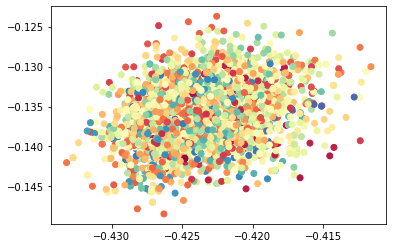

tensor([[0.1795, 0.0576],
        [0.0576, 0.0185]], grad_fn=<DivBackward0>)
Epoch=120, loss=87.7767, time=1.2230
loss before neg tensor(18.0870, dtype=torch.float64, grad_fn=<SubBackward0>)
loss after neg tensor(69.6897, grad_fn=<NegBackward0>)
loss corr tensor(1.2986e-06, grad_fn=<MulBackward0>)
loss final tensor(87.7767, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch=121, loss=87.7767, time=1.0156
loss before neg tensor(18.0870, dtype=torch.float64, grad_fn=<SubBackward0>)
loss after neg tensor(69.6897, grad_fn=<NegBackward0>)
loss corr tensor(6.4252e-06, grad_fn=<MulBackward0>)
loss final tensor(87.7767, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch=122, loss=87.7767, time=1.0118
loss before neg tensor(18.0870, dtype=torch.float64, grad_fn=<SubBackward0>)
loss after neg tensor(69.6897, grad_fn=<NegBackward0>)
loss corr tensor(4.8208e-06, grad_fn=<MulBackward0>)
loss final tensor(87.7767, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch=123, loss=87.7767, time=0.9932
loss

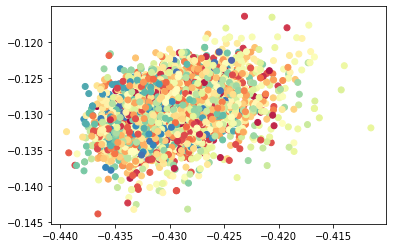

tensor([[0.1850, 0.0558],
        [0.0558, 0.0169]], grad_fn=<DivBackward0>)
Epoch=130, loss=87.7767, time=1.1813
loss before neg tensor(18.0870, dtype=torch.float64, grad_fn=<SubBackward0>)
loss after neg tensor(69.6897, grad_fn=<NegBackward0>)
loss corr tensor(5.1291e-06, grad_fn=<MulBackward0>)
loss final tensor(87.7767, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch=131, loss=87.7767, time=0.9685
loss before neg tensor(18.0870, dtype=torch.float64, grad_fn=<SubBackward0>)
loss after neg tensor(69.6897, grad_fn=<NegBackward0>)
loss corr tensor(4.1550e-06, grad_fn=<MulBackward0>)
loss final tensor(87.7767, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch=132, loss=87.7767, time=0.9640
loss before neg tensor(18.0870, dtype=torch.float64, grad_fn=<SubBackward0>)
loss after neg tensor(69.6897, grad_fn=<NegBackward0>)
loss corr tensor(2.3228e-06, grad_fn=<MulBackward0>)
loss final tensor(87.7767, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch=133, loss=87.7767, time=1.0147
loss

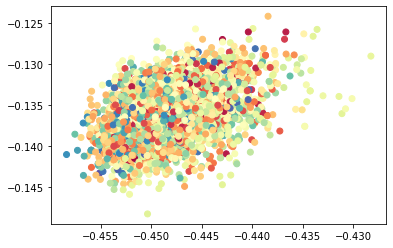

tensor([[0.2012, 0.0611],
        [0.0611, 0.0185]], grad_fn=<DivBackward0>)
Epoch=140, loss=87.7767, time=1.1888
loss before neg tensor(18.0870, dtype=torch.float64, grad_fn=<SubBackward0>)
loss after neg tensor(69.6897, grad_fn=<NegBackward0>)
loss corr tensor(5.0789e-06, grad_fn=<MulBackward0>)
loss final tensor(87.7767, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch=141, loss=87.7767, time=0.9717
Early stopping at epoch 141!
Loading 121th epoch


<Figure size 432x288 with 0 Axes>

(array([[4000.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
            0.],
        [   0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
         4000.]]),
 array([-0.4915192 , -0.4570491 , -0.42257902, -0.3881089 , -0.3536388 ,
        -0.3191687 , -0.2846986 , -0.2502285 , -0.2157584 , -0.18128829,
        -0.14681819], dtype=float32),
 <a list of 2 BarContainer objects>)

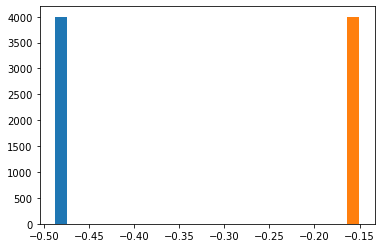

<Figure size 432x288 with 0 Axes>

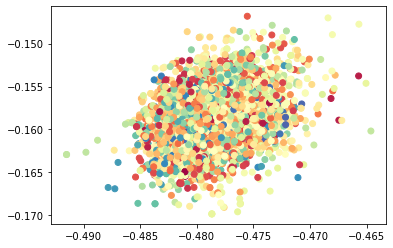

tensor([[0.2291, 0.0760],
        [0.0760, 0.0252]], grad_fn=<DivBackward0>)


In [120]:
model2, target_graph_index, vals, knn_dists=  train_gnumap(new_data, 
                                     target=None, hid_dim=1054, dim=2, 
                                     n_layers=3, must_propagate= [True, True, True, True, True],
                                     method = 'laplacian', alpha=0.5, 
                                     gnn_type='symmetric', repulsion_strength=100,
                                     norm='uniform', neighbours=5,
                                      beta=1, patience=20, epochs=1000,
                                      lr=1e-1, 
                                    wd=1e-4,
                                    lambd_corr=1e-4,
                                       min_dist=0.01,
                       subsampling=100000)
out = model2(new_data.x.float(), new_data.edge_index)
plt.figure()
plt.hist(out.detach().numpy())
plt.show()
u = out.detach().numpy()
plt.figure()
plt.scatter(u[:,0], u[:,1], c = t, 
            cmap="Spectral")
plt.show()
print(torch.mm(out.T, out)/ new_data.num_nodes)

(array([1.5029e+04, 2.4600e+02, 1.2200e+02, 8.0000e+01, 2.4000e+01,
        2.1000e+01, 1.3000e+01, 6.0000e+00, 9.0000e+00, 8.0040e+03]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

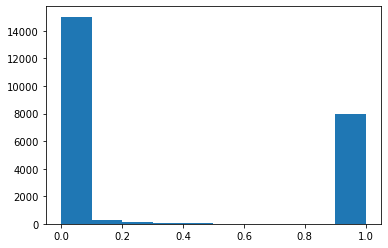

In [95]:
plt.hist(vals)

In [70]:
new_edge_index, new_edge_attr = remove_self_loops(new_data.edge_index, new_data.edge_weight)

In [71]:
knn_dists
sigmas, rhos = smooth_knn_dist(
            knn_dists,
            float(2),
            local_connectivity=float(1.),
             )

array([[0.71168445, 1.74497943, 2.1098423 , ..., 0.        , 0.        ,
        0.        ],
       [1.23018915, 1.8916938 , 2.11493388, ..., 0.        , 0.        ,
        0.        ],
       [1.56787147, 2.11155062, 2.61181357, ..., 4.45960105, 0.        ,
        0.        ],
       ...,
       [1.36817128, 1.78175457, 2.22981106, ..., 0.        , 0.        ,
        0.        ],
       [1.17968252, 1.22132076, 1.9007367 , ..., 0.        , 0.        ,
        0.        ],
       [1.14463286, 1.21578641, 1.26692256, ..., 0.        , 0.        ,
        0.        ]])

In [82]:
vals = []
for i in range(len(new_edge_attr))[:100]:
    vals+= [ np.exp(-(np.max([new_edge_attr.numpy()[i] - rhos[new_edge_index[0,i]], 0])) /
                    (sigmas[new_edge_index[0,i]]))]
    print([i, np.exp(-(np.max([new_edge_attr.numpy()[i] - rhos[new_edge_index[0,i]], 0])) /
                    (sigmas[new_edge_index[0,i]]))])

[0, 1.6395306207727425e-109]
[1, 5.025210092546169e-109]
[2, 7.867661885529068e-124]
[3, 1.8295712323748618e-51]
[4, 0.0]
[5, 1.0]
[6, 1.0]
[7, 1.0]
[8, 1.0]
[9, 1.0]
[10, 7.366016027651263e-122]
[11, 1.0]
[12, 3.3996684977060143e-23]
[13, 1.0]
[14, 1.0]
[15, 2.2831595972143054e-132]
[16, 1.0]
[17, 1.0]
[18, 1.0]
[19, 0.14168396615462223]
[20, 1.0]
[21, 1.0]
[22, 1.0]
[23, 1.0]
[24, 1.0]
[25, 1.0]
[26, 1.0]
[27, 1.0377136023666879e-127]
[28, 1.0]
[29, 9.13605678074032e-80]
[30, 4.474910184404393e-74]
[31, 1.0]
[32, 1.0]
[33, 1.0]
[34, 1.6089978028902452e-84]
[35, 1.0]
[36, 9.979085184330304e-282]
[37, 1.0]
[38, 1.0]
[39, 1.0]
[40, 1.0]
[41, 1.0]
[42, 1.0]
[43, 1.0]
[44, 1.0]
[45, 0.9321398468532998]
[46, 1.0]
[47, 1.0]
[48, 1.0]
[49, 1.0]
[50, 1.0]
[51, 1.0]
[52, 1.0]
[53, 1.0]
[54, 1.0]
[55, 1.0]
[56, 5.466433963782591e-54]
[57, 0.0]
[58, 1.0]
[59, 5.196845429375343e-146]
[60, 1.0]
[61, 1.0]
[62, 1.0]
[63, 1.0]
[64, 2.4523289105187905e-179]
[65, 1.0]
[66, 1.0]
[67, 1.0]
[68, 1.0]
[69,

In [78]:
i = 5
print(new_edge_index[:,i], new_edge_attr.numpy()[i] , rhos[new_edge_index[0,i]], sigmas[new_edge_index[0,i]])
print(np.max(new_edge_attr.numpy()[i] - rhos[new_edge_index[0,i]], 0)/sigmas[new_edge_index[0,i]])

tensor([   0, 3989]) 0.3558422266289477 0.71168447 0.0013764302
-258.5254598964768


In [81]:
np.max([new_edge_attr.numpy()[i] - rhos[new_edge_index[0,i]], 0]
      )

0.0

In [75]:
np.max(new_edge_attr.numpy()[i] - rhos[new_edge_index[0,i]], 0)/sigmas[new_edge_index[0,i]]

250.48736514232576

(array([2.535e+03, 1.265e+03, 1.580e+02, 2.300e+01, 1.400e+01, 2.000e+00,
        1.000e+00, 1.000e+00, 0.000e+00, 1.000e+00]),
 array([ 0.1000171,  1.6779159,  3.2558148,  4.8337135,  6.4116125,
         7.9895115,  9.56741  , 11.1453085, 12.723207 , 14.301106 ,
        15.879005 ], dtype=float32),
 <BarContainer object of 10 artists>)

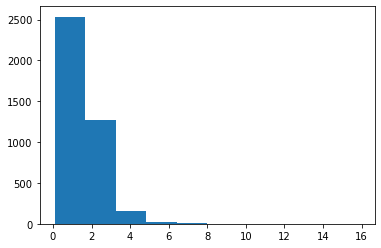

In [54]:
plt.hist(rhos)

In [40]:
#xx = torch.ones((X.shape[0], 10))
new_data2 = copy.deepcopy(new_data)
new_data2.x =  new_data.x[:,:2]
model2, target_index =  train_gnumap(new_data2, 
                                     target=None, hid_dim=256, dim=2, 
                                     n_layers=1, must_propagate= [True, True, True, True, True],
                                     method = 'laplacian', alpha=0.5, 
                                     gnn_type='symmetric', repulsion_strength=1.,
                                     norm='standardize', neighbours=2,
                                    beta=1, patience=20, epochs=1000,
                                       lr=1e-2, 
                                       wd=1e-4,
                                        lambd_corr=1.,
                                       min_dist=0.001,
                       subsampling=100000)
out = model2(new_data2.x.float(), new_data.edge_index)
plt.figure()
plt.hist(out.detach().numpy())
plt.show()
u = out.detach().numpy()
plt.figure()
plt.scatter(u[:,0], u[:,1], c = t, 
            cmap="Spectral")
plt.show()
print(torch.mm(out.T, out)/ new_data.num_nodes)

/var/folders/5d/vnx7yths3n3f_d7862mdryz80000gn/T/ipykernel_84604/4093325387.py:47: RuntimeWarning: overflow encountered in exp
  vals = [ np.exp(-(np.max(new_edge_attr.numpy()[i] - rhos[new_edge_index[0,i]], 0)) /


inf
[3.5674467177298918e+224, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0000088275335732, inf, 0.0, 1.0000373457655027, 3.090933811944088e-300, 6.639466614921549e-197, 0.0, 4.143418844157581e-263, inf, 0.0, 1.2454440519811808e-217, 2.4294484046672182e-208, 0.0, 7.508337153173078e-109, 0.9999903449799196, 3.2663326578361083e-262, inf, 0.0, 0.0, 1.0000378154950407, 0.0, inf, 1.5061379858529469e-44, 9.844121056273566e-178, 1.4442475116674986e-180, 0.9999277404509868, inf, 0.0, 1.0000097451742924, 0.0, 0.0, inf, 2.8133271080187676e-132, 2.582055765433886e-247, 1.0023078222668122e-179, 0.0, 1.0000290556846976, inf, 0.0, 0.0, 0.9999944052142432, 2.2988174158087955e-259, inf, 3.968382677597432e-99, 0.0, 0.9999566897469838, 0.0, 0.0, inf, 0.0, 0.9999690096918677, 2.385417277892708e-30, 1.1332190448637058e-244, 2.7532769556858e-111, 6.639298604918169e-16, inf, 1.5935504100333738e-240, 1.1012511820678954e-86, 1.883289261208719e-18, 1.0000168008459474, inf, 6.593382420909614e-193, 0.0, 0.0, 0.9999864473170066, 


KeyboardInterrupt

